# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
#This is predictive model study that incorporates a variety of factors that
#influence the overall price of a car. Given the nature of data it can be seen 
#that not all independent variables are numerical. Therefore categorical
#values can be encoded before building linear regression model.  It is to be explored and 
#determined whether price is influenced by 
#all or few strong factors. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline  
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

In [13]:
df = pd.read_csv('data/vehicles.csv')

In [14]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [15]:
#remove redundant non-informative id columns.
#Model of car is too fine grained and difficult to group by so will return manufacturer only.

df = df.drop(['id', 'VIN','region', 'model','state'], axis=1)

categorical_columns = ['manufacturer',
                      'cylinders','fuel',
                       'drive','size','type','paint_color','title_status','transmission','condition']
#assign 'Unknown' category since missing values are too many

df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# One-hot encode 'title_status' and 'transimission' with custom mapping
df['title_status_encoded'] = df['title_status'].apply(lambda x: 1 if x == 'clean' else 0)
df['transmission_encoded'] = df['transmission'].apply(lambda x: 1 if x == 'automatic' else 0)


ordinal_mapping = {'Unknown': 0, 'other': 1,
                   'cylinders': 2,'3 cylinders': 3, '4 cylinders': 4, '5 cylinders':5,
                   '6 cylinders': 6, '8 cylinders': 7,'10 cylinders': 8,'12 cylinders':9}
df['cylinders_encoded'] = df['cylinders'].map(ordinal_mapping)


ordinal_mapping2 = {'Unknown': 0, 'salvage':1,'fair':2,'good':3,'excellent':4,'like new': 5,'new': 6}
df['condition_encoded'] = df['condition'].map(ordinal_mapping2)


categorical_columns2 = ['manufacturer', 'fuel','drive', 'size', 'type', 'paint_color']
for col in categorical_columns2:
    # Calculate the mean of the target variable ('price') for each category
    mean_target = df.groupby(col)['price'].mean()
    
    # Replace categories in the column with their corresponding mean target value
    df[col] = df[col].map(mean_target)
    df[col] = np.log1p(df[col])



# Count the number of "Unknown" values in each row
unknown_counts = (df == 'Unknown').sum(axis=1)

#Remove largely empty rows.  
df = df[unknown_counts <= 5]


#feature engineer age and mileage_per_year. 
df = df.dropna(subset=['year'])
df['car_age'] = 2025 - df['year']
df['mileage_per_year'] = df['odometer'] / df['car_age']

df.drop(columns=['cylinders','transmission','year','odometer','title_status', 'condition'], inplace=True)

df['price'] = np.log1p(df['price']) 
df.head()



,price,manufacturer,fuel,drive,size,type,paint_color,title_status_encoded,transmission_encoded,cylinders_encoded,condition_encoded,car_age,mileage_per_year
27,10.422013,10.040239,10.941679,11.720569,11.073653,12.558125,12.003900,1,0,7,3,11.0,5265.727273
28,10.025307,12.332543,10.941679,11.720569,11.073653,12.558125,9.785795,1,0,7,3,15.0,4748.600000
29,10.586357,12.332543,10.941679,11.720569,11.073653,12.558125,9.926007,1,0,7,3,5.0,3832.000000
30,10.341452,9.682927,10.941679,11.720569,11.073653,12.558125,9.926007,1,0,7,3,8.0,5140.500000
31,9.615872,12.363536,10.941679,12.274159,12.306995,9.991669,10.039424,1,1,6,4,12.0,10666.666667


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [16]:



# Prepare data
y = df[['price']]
X = df.drop(columns=['price'], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a pipeline with Ridge instead of LinearRegression to match the parameter grid
#scaled_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])  # Changed to use 'ridge' consistently

scaled_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Add imputer to handle NaN values
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
scaled_pipe.fit(X_train, y_train)


scaled_pipe.fit(X_train, y_train)

train_preds = scaled_pipe.predict(X_train)
test_preds = scaled_pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Define hyperparameter grid for alpha values
param_grid = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0,200.0,300.0]}  # Different alpha values

# Use GridSearchCV to find the best alpha value
grid_search = GridSearchCV(estimator=scaled_pipe,  # Changed from 'pipeline' to 'scaled_pipe'
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
best_alpha = grid_search.best_params_['ridge__alpha']
best_score = -grid_search.best_score_  # Convert negative MSE back to positive

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (MSE): {best_score:.2f}")

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)

print(f"Test MSE: {test_mse:.2f}")



Train MSE: 9.071767487383248
Test MSE: 9.298624494112703
Best Alpha: 300.0
Best Cross-Validation Score (MSE): 9.09
Test MSE: 9.30


In [19]:



auto_y = df[['price']]
auto_X = df.drop(columns=['price'], axis=1)


auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(auto_X, auto_y, 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

# Add an imputer step to handle missing values before polynomial features
sequential_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Add imputation step to handle NaN values
    ('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
    ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=4)),
    ('linreg', LinearRegression())
])

sequential_pipe.fit(auto_X_train, auto_y_train)
sequential_train_mse = mean_squared_error(auto_y_train, sequential_pipe.predict(auto_X_train))
sequential_test_mse = mean_squared_error(auto_y_test, sequential_pipe.predict(auto_X_test))



print(f'Train MSE: {sequential_train_mse}')
print(f'Test MSE: {sequential_test_mse}')



Train MSE: 8.8364523245488
Test MSE: 9.073167744173357


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [3]:
#After initial analysis and closer look at data - it was determined
#that more meaningful preprocessing is needed . MSE is too high when 
#all variables are retained . 

df = pd.read_csv('data/vehicles.csv')

In [4]:
#remove redundant non-informative id columns.
#Model of car is too fine grained and difficult to group by.

df = df.drop(['id', 'VIN','region','state','model'], axis=1)

categorical_columns = ['manufacturer',
                      'cylinders','fuel',
                       'drive','size','type','paint_color','title_status','transmission','condition']
#assign 'Unknown' category since missing values are too many

df[categorical_columns] = df[categorical_columns].fillna('Unknown')

#cannot determine significance of 'other' so dropping these
df = df[(df['transmission'] != 'other') & (df['cylinders'] != 'other')]

# Count the number of "Unknown" values in each row
unknown_counts = (df == 'Unknown').sum(axis=1)

#Remove largely empty rows.  
df = df[unknown_counts <= 5]

#one hot encoding for these columns where ranking can be intutively assigned.
df['title_status_encoded'] = df['title_status'].apply(lambda x: 1 if x == 'clean' else 0)

ordinal_mapping2 = {'Unknown':0,'salvage': 1,'fair':2,'good':3,'excellent':4,'like new': 5,'new': 6}
df['condition_encoded'] = df['condition'].map(ordinal_mapping2)


categorical_columns2 = ['cylinders','manufacturer','transmission', 'fuel','drive', 'size', 'type', 'paint_color']


#dropping price rows that may be too low and outliers.
df = df[df['price'] > 1000]
for col in categorical_columns2:
    # Calculate the mean of the target variable ('price') for each category
    mean_target = df.groupby(col)['price'].mean()   
    # Replace categories in the column with their corresponding mean target value
    df[col] = df[col].map(mean_target)
    #smoothing values
    df[col] = np.log1p(df[col])
    

#feature engineer age and mileage_per_year. 
df = df.dropna(subset=['year'])
df['car_age'] = 2025 - df['year']

#dropping odometer value that may be too low and outliers/unrealistic.
df = df[df['odometer'] > 500]

df['mileage_per_year'] = df['odometer'] / df['car_age']

#because of encoded columns these originals can be dropped
df.drop(columns=['year','odometer','title_status','condition'], inplace=True)

#smoothing values
df['price'] = np.log1p(df['price']) 

df.head()


,price,manufacturer,cylinders,fuel,transmission,drive,size,type,paint_color,title_status_encoded,condition_encoded,car_age,mileage_per_year
31,9.615872,12.619420,9.868023,9.822593,11.227395,12.511035,12.562601,10.170711,10.058391,1,4,12.0,10666.666667
34,10.463132,9.743296,9.868023,9.822593,11.227395,10.292655,10.047120,10.170711,9.860133,1,4,6.0,7166.666667
37,8.412055,9.998819,9.868023,9.822593,11.227395,10.292655,10.047120,9.952316,9.936221,1,4,33.0,5818.181818
55,9.898525,12.619420,12.478810,13.341407,11.227395,10.292655,12.562601,12.876099,9.738701,1,3,21.0,4190.476190
59,9.546884,9.460420,9.868023,9.822593,11.227395,9.474660,12.562601,9.534702,9.784136,1,4,13.0,7307.692308


In [5]:

# Include 'price' in the numeric columns for correlation calculation
# after better preprocessing measure -determine initial correlation values 

numeric_columns = df.select_dtypes(include=['number']).columns  # Remove .drop('price')
corr_matrix = df[numeric_columns].corr()

# Extract correlations with 'price' and filter for |correlation| > 0.4
price_corr = corr_matrix['price'].abs().sort_values(ascending=False)
high_corr_features = price_corr[(price_corr > 0.3) & (price_corr.index != 'price')]

print("Features with correlation > 0.3 with 'price':")
print(high_corr_features)


Features with correlation > 0.3 with 'price':
car_age    0.411040
type       0.316162
Name: price, dtype: float64


In [7]:

#Using same model as before but with highly correlated features only.
# Prepare data
y = df[['price']]
X = df[['car_age','type']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a pipeline with Ridge instead of LinearRegression to match the parameter grid
#scaled_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])  # Changed to use 'ridge' consistently

scaled_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Add imputer to handle NaN values
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
scaled_pipe.fit(X_train, y_train)


scaled_pipe.fit(X_train, y_train)

train_preds = scaled_pipe.predict(X_train)
test_preds = scaled_pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Define hyperparameter grid for alpha values
param_grid = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0,200.0,300.0]}  # Different alpha values

# Use GridSearchCV to find the best alpha value
grid_search = GridSearchCV(estimator=scaled_pipe,  # Changed from 'pipeline' to 'scaled_pipe'
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
best_alpha = grid_search.best_params_['ridge__alpha']
best_score = -grid_search.best_score_  # Convert negative MSE back to positive

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (MSE): {best_score:.2f}")

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)

print(f"Test MSE: {test_mse:.2f}")


Train MSE: 0.4964730225539009
Test MSE: 0.4951233114587777
Best Alpha: 10.0
Best Cross-Validation Score (MSE): 0.50
Test MSE: 0.50


In [15]:
scaled_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('ridge', Ridge())])

In [10]:
#Using same model as before but with highly correlated features only.
# Prepare data
auto_y = df[['price']]
auto_X = df[['car_age','type']]

auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(auto_X, auto_y, 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

sequential_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
    ('linreg', LinearRegression())
])

sequential_pipe.fit(auto_X_train, auto_y_train)
sequential_train_mse = mean_squared_error(auto_y_train, sequential_pipe.predict(auto_X_train))
sequential_test_mse = mean_squared_error(auto_y_test, sequential_pipe.predict(auto_X_test))

feature_names_ = sequential_pipe.named_steps['poly_features'].get_feature_names_out()


print(f"Test MSE: {sequential_test_mse:.2f}")


Test MSE: 0.29


In [11]:
sequential_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linreg', LinearRegression())])

In [12]:

# Extract feature names generated by PolynomialFeatures
feature_names_ = sequential_pipe.named_steps['poly_features'].get_feature_names_out(auto_X.columns)

# Extract coefficients from LinearRegression
coefficients = sequential_pipe.named_steps['linreg'].coef_

# Create a DataFrame of features and their corresponding coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names_, 'Coefficient': coefficients.flatten()})

# Print the DataFrame
print(coefficients_df)


          Feature  Coefficient
0         car_age    -0.931724
1            type     1.601400
2       car_age^2     0.323171
3    car_age type     0.023397
4          type^2     0.251573
5       car_age^3    -0.025525
6  car_age^2 type    -0.014784
7  car_age type^2    -0.002534
8          type^3    -0.352792


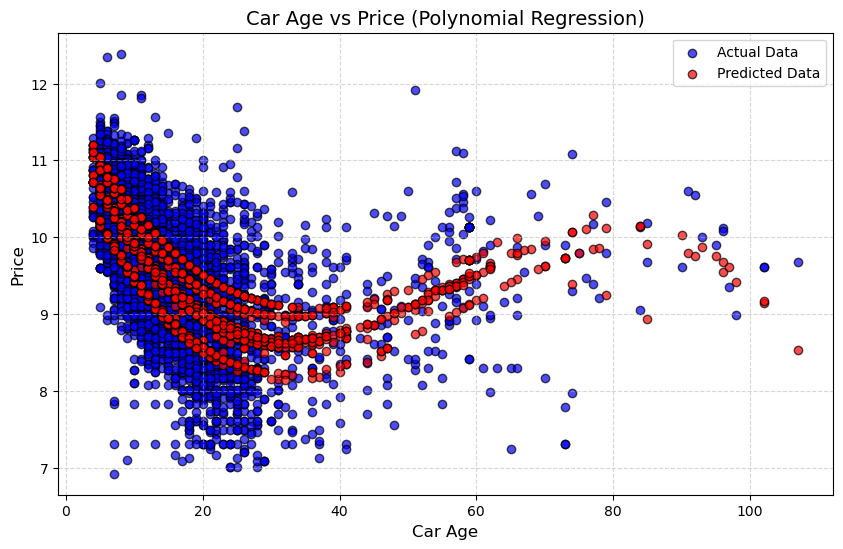

In [13]:

predicted_prices = sequential_pipe.predict(auto_X_test)

# Scatter plot of actual data points
plt.figure(figsize=(10, 6))
plt.scatter(auto_X_test['car_age'], auto_y_test, color='blue', alpha=0.7, edgecolor='k', label='Actual Data')

# Overlay regression predictions (for car_age only, as type is categorical)
plt.scatter(auto_X_test['car_age'], predicted_prices, color='red', alpha=0.7, edgecolor='k', label='Predicted Data')

# Add labels and title
plt.title('Car Age vs Price (Polynomial Regression)', fontsize=14)
plt.xlabel('Car Age', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

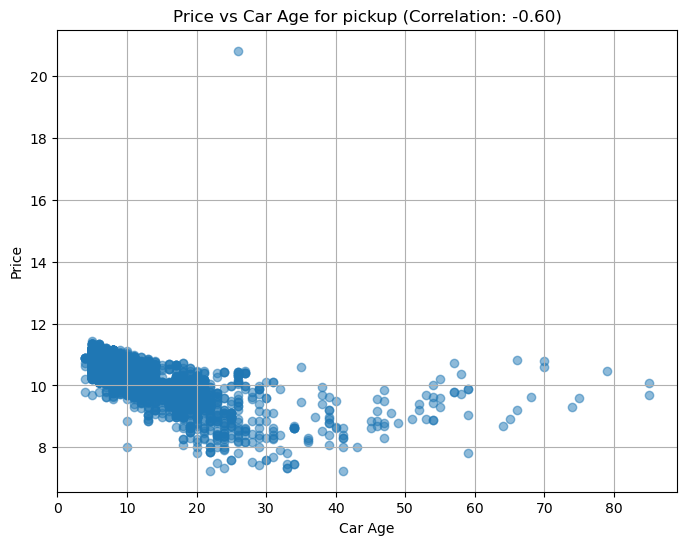

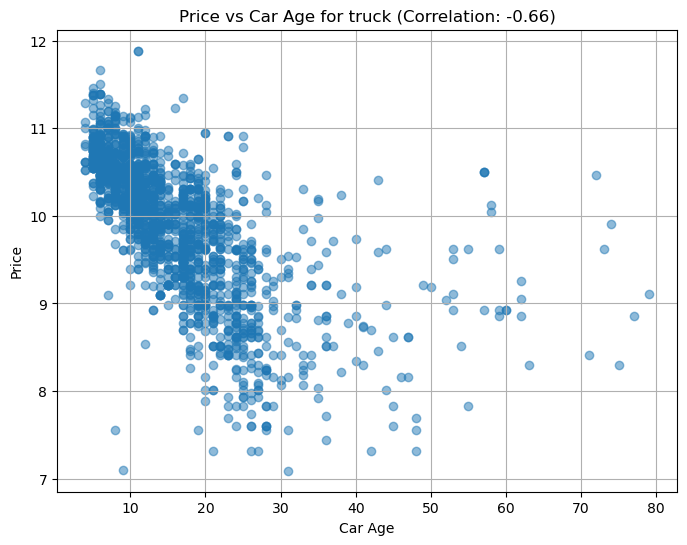

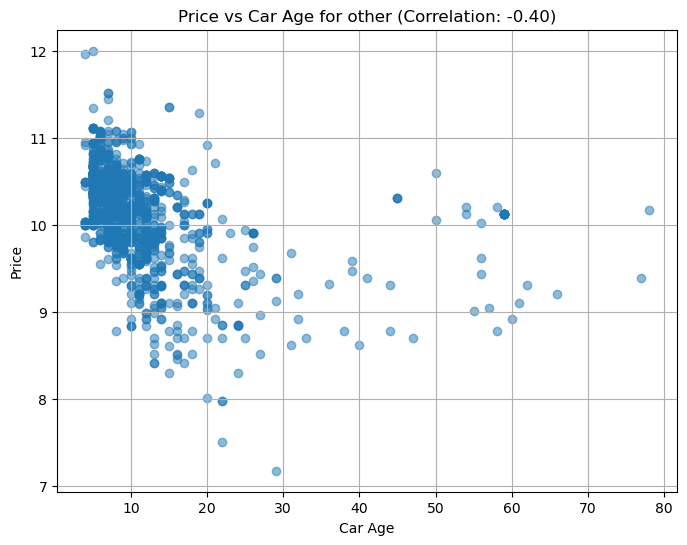

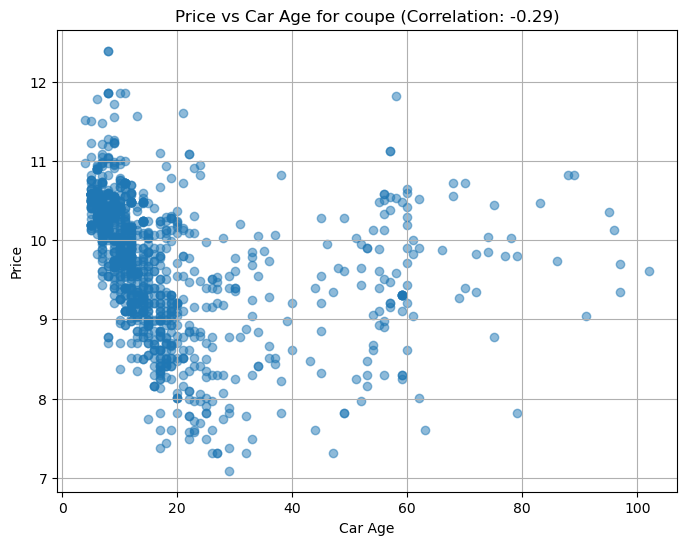

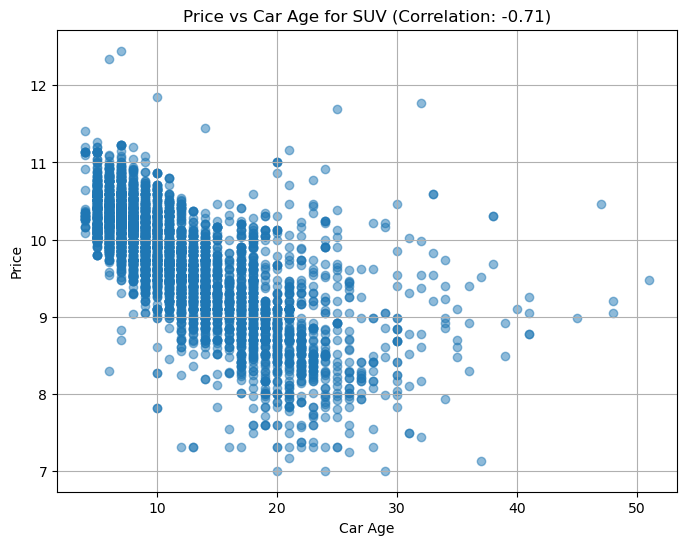

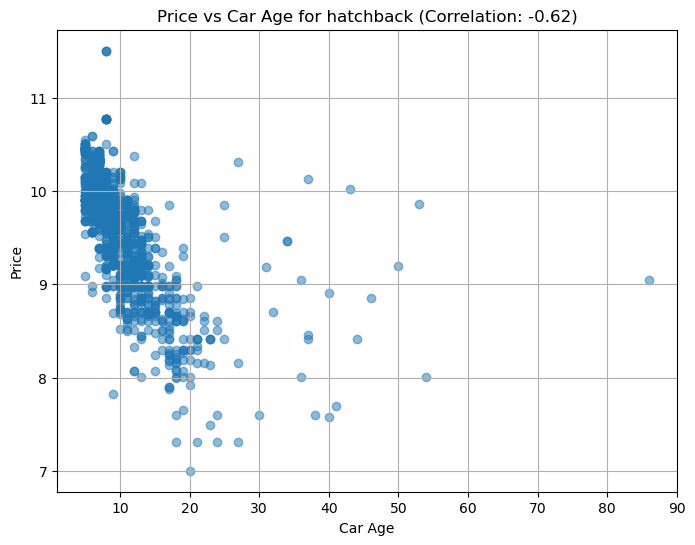

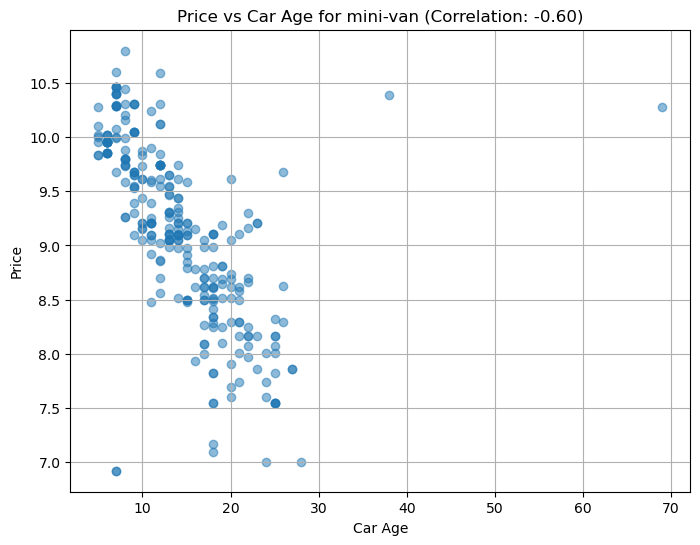

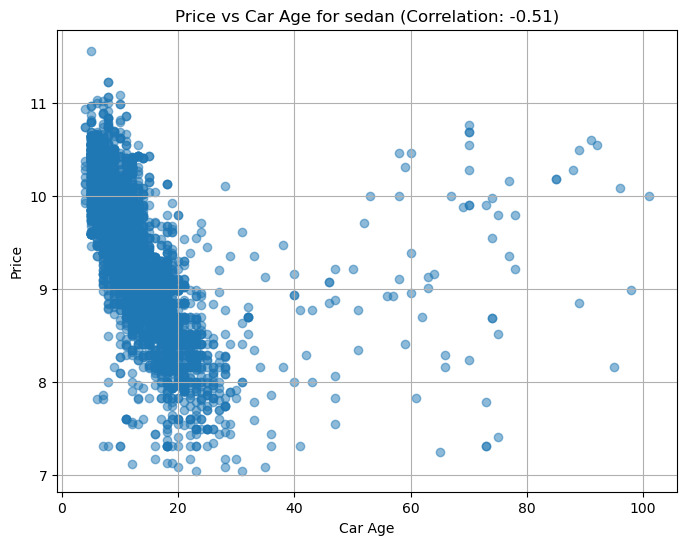

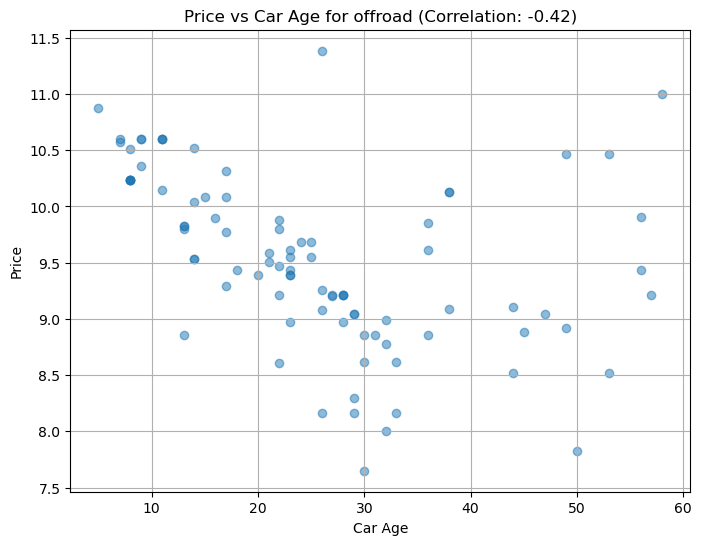

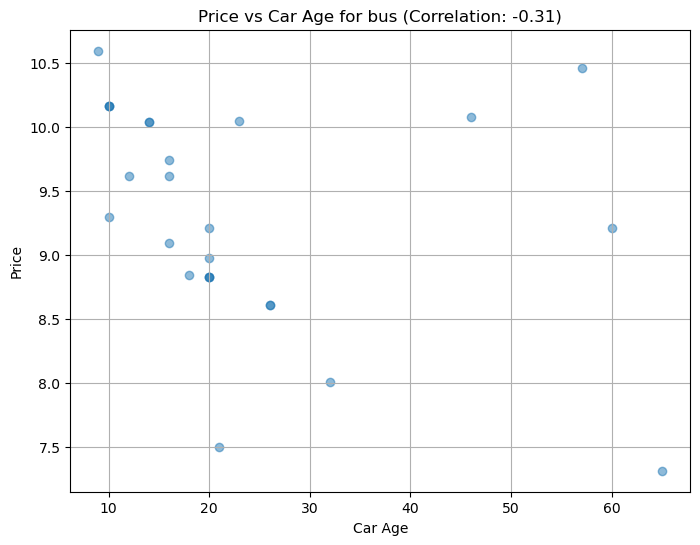

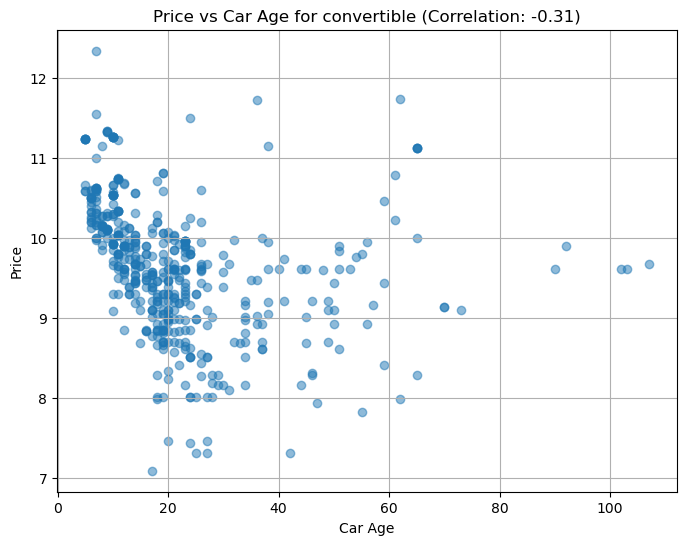

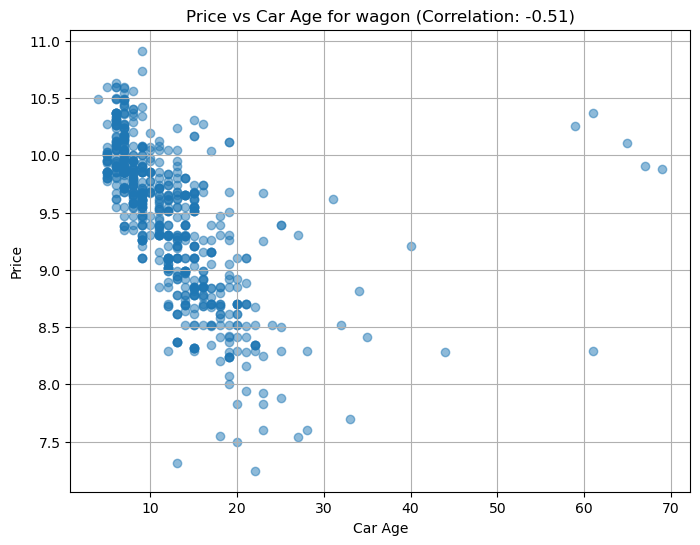

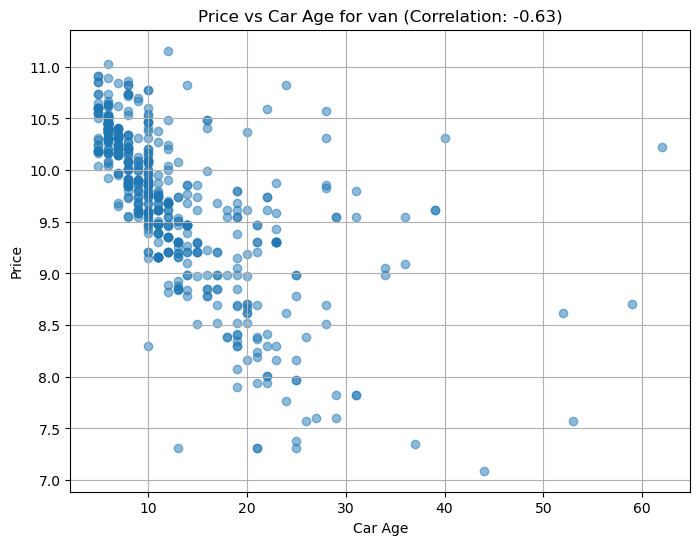

Correlation Coefficients by Car Type:
pickup: -0.60
truck: -0.66
other: -0.40
coupe: -0.29
SUV: -0.71
hatchback: -0.62
mini-van: -0.60
sedan: -0.51
offroad: -0.42
bus: -0.31
convertible: -0.31
wagon: -0.51
van: -0.63


In [32]:
#Repeat analysis and this time run correlations on different 'type' subsets. 

df = pd.read_csv('data/vehicles.csv')

#preprocessing 
df = df[df['price'] > 1000]
df = df[df['odometer'] > 500]

#smoothing curve
df['price'] = np.log1p(df['price']) 

#calculate car age as before
df = df.dropna(subset=['type'])

df = df.dropna(subset=['year'])
df['car_age'] = 2025 - df['year']

# Dictionary to store correlation coefficients for each car type
correlation_dict = {}

# Loop through each unique car type
unique_types = df['type'].unique()

for car_type in unique_types:
    # Select rows where the 'type' column matches the current car_type
    subset = df[df['type'] == car_type]

    # Calculate the correlation coefficient between 'car_age' and 'price'
    if len(subset) > 1:  # Ensure there are enough data points to calculate correlation
        correlation = subset['car_age'].corr(subset['price'])
    else:
        correlation = np.nan  # Not enough data points for correlation

    # Store the correlation coefficient in the dictionary
    correlation_dict[car_type] = correlation

    # Plot scatter plot for car_age vs price for the current car_type
    plt.figure(figsize=(8, 6))
    plt.scatter(subset['car_age'], subset['price'], alpha=0.5)
    plt.title(f'Price vs Car Age for {car_type} (Correlation: {correlation:.2f})')
    plt.xlabel('Car Age')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

# Display all correlation coefficients. Some types show stable/elevated prices regardless of car age. 
print("Correlation Coefficients by Car Type:")
for car_type, corr in correlation_dict.items():
    print(f"{car_type}: {corr:.2f}")



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
'''based on the analysis it is determined that car age seems to be the 
strongest indicator for influencing price of car. However it is clear that prices may remain elevated  
for increasing age of car for certain types. This means that car prices remain stable and elevated for certain types. For eg. type
of coupe and convertible are likely to sell for higher price even with higher age of car. As next steps the recommendation is to isolate 
the subset of high car prices at higher car age and analyse this subset separately like it was done with 'type''''